In [15]:
%reset -f

import numpy as np
from scipy import signal, constants, fft
import matplotlib.pyplot as plt
import SpectralData as SD
import tdf

%load_ext autoreload
%autoreload 2

# function to visualize the different steps of Time-domain filtering
def plottdfsteps(f, y_f, y_tdf, t, At, At_f, w_f, w_t, tag = '', b_plotfilter = 0, f1=1000, f2=1500, t1=-500, t2=1500):
    _, (ax0, ax1, ax2, ax3) =plt.subplots(4, figsize=(7.5,8))
    ax01, ax21 = ax0.twinx(), ax2.twinx()
    f1, f2   = (np.abs(f - f1)).argmin(), (np.abs(f  - f2)).argmin()
    t1, t2   = (np.abs(t - t1)).argmin(), (np.abs(t  - t2)).argmin()
    
    ax0.plot(f[(f1-20).clip(min=0):f2+20], y_f[(f1-20).clip(min=0):f2+20].real)
    ax1.plot(t[t1:t2], At[t1:t2].real)
    
    ax2.plot(t[t1:t2], (At_f.real)[t1:t2])

    ax3.plot(f[(f1-20).clip(min=0):f2+20], y_tdf[(f1-20).clip(min=0):f2+20].real, label = tag)
    #ax3.legend()
    ax0.set_xlabel("wavenumber ($cm^{-1}$)"), ax0.set_ylabel("$|H|$")
    ax1.set_xlabel("time(fs)"), ax1.set_ylabel("EOS (a.u.)")
    ax2.set_xlabel("time(fs)"), ax2.set_ylabel("EOS (a.u.)")
    ax3.set_xlabel("wavenumber ($cm^{-1}$)"), ax3.set_ylabel("$|H|$")
    ax0.set_title('Step 1 - Apply filter to the FD to select region of interest')
    ax1.set_title('Step 2 - Calculate the TD-representation of the transfer function')
    ax2.set_title('Step 3 - Apply filter within the TD to filter out noise')
    ax3.set_title('Step 4 - Go back to the FD')

    if b_plotfilter:
        ax21.plot(t[t1:t2],w_t[t1:t2], ls='--', color='tab:orange', label=(tag+' - filter function'))
        ax01.plot(f[(f1-20).clip(min=0):f2+20],w_f[(f1-20).clip(min=0):f2+20], ls='--', color='tab:orange', label=(tag+' - filter function'))
        ax01.set_ylabel("filter function"), ax21.set_ylabel("filter function")
        #ax01.legend(), ax21.legend()

    plt.tight_layout()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Considerations when applying time-domain filtering
## step-by-step

### Fig S1

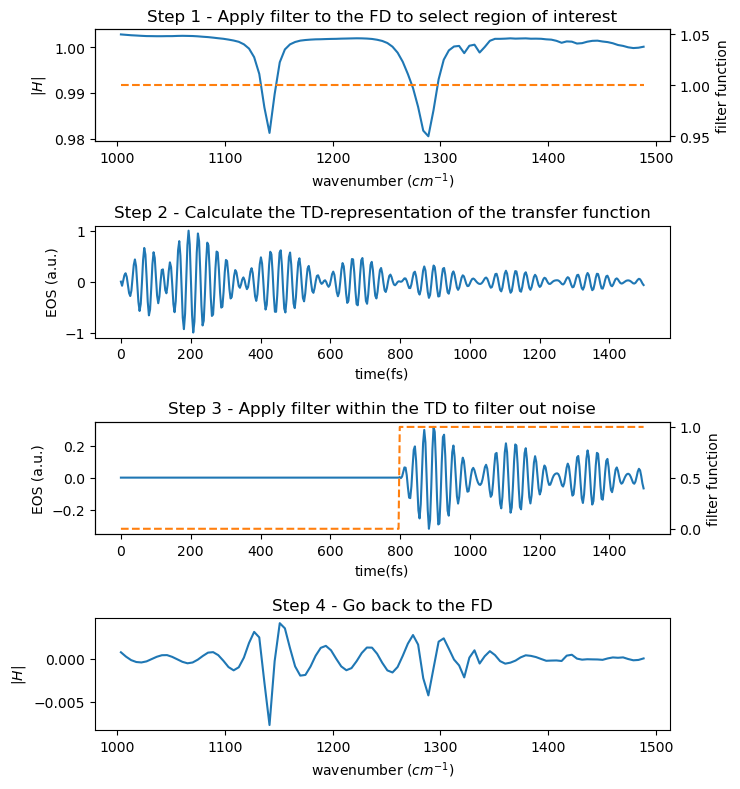

In [16]:
f, y = np.load(r'data\DMSO2.npz')['x'], np.load(r'data\DMSO2.npz')['y']
t1 = 800
f1, f2   = (np.abs(f - 1000)).argmin(), (np.abs(f  - 1500)).argmin()

t = fft.rfftfreq(f.size, d=np.diff(f*constants.c*100).mean())*1E15 # calculated time-axis
w_f = SD.tukeyF(f,1000,1500,0)

y_f, y_tdf, t, At, At_f, w_f, w_t = tdf.rtdf(f, (y.real-1)*w_f+1, t1, w_f=1)
plottdfsteps(f, y_f, y_tdf, t, At, At_f, w_f, w_t, tag='Heavieside TD-filter', b_plotfilter = 1, f1=1100, f2=1400)

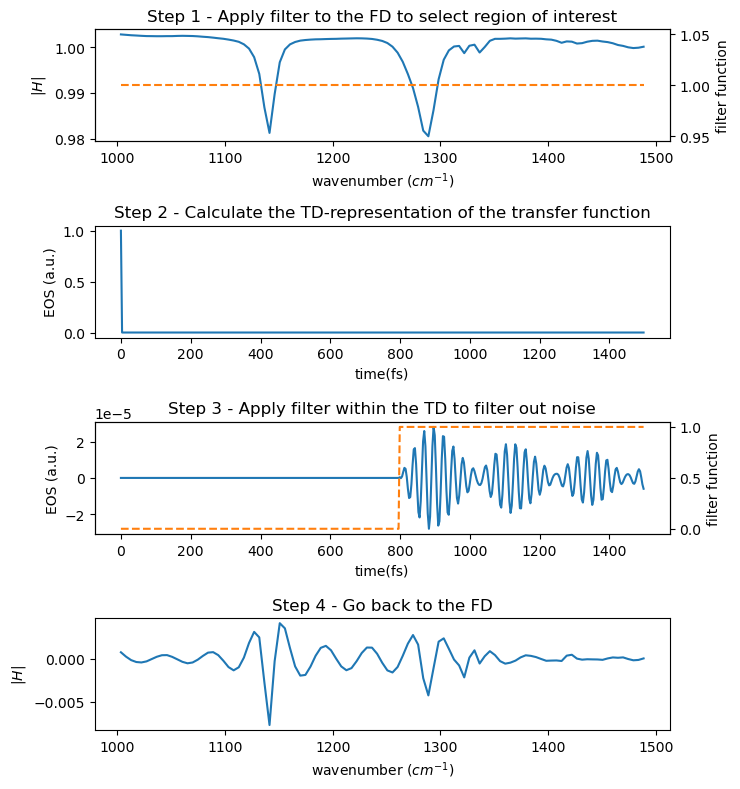

In [17]:
f, y = np.load(r'data\DMSO2.npz')['x'], np.load(r'data\DMSO2.npz')['y']
t1 = 800
f1, f2   = (np.abs(f - 1000)).argmin(), (np.abs(f  - 1500)).argmin()

t = fft.rfftfreq(f.size, d=np.diff(f*constants.c*100).mean())*1E15 # calculated time-axis
w_f = SD.tukeyF(f,1000,1500,0)

y_f, y_tdf, t, At, At_f, w_f, w_t = tdf.rtdf(f, (y.real-1)*w_f+1, t1, w_f=1, offset=0, b_remove_dc = False)
plottdfsteps(f, y_f, y_tdf, t, At, At_f, w_f, w_t, tag='Heavieside TD-filter', b_plotfilter = 1, f1=1100, f2=1400)

### Fig S2

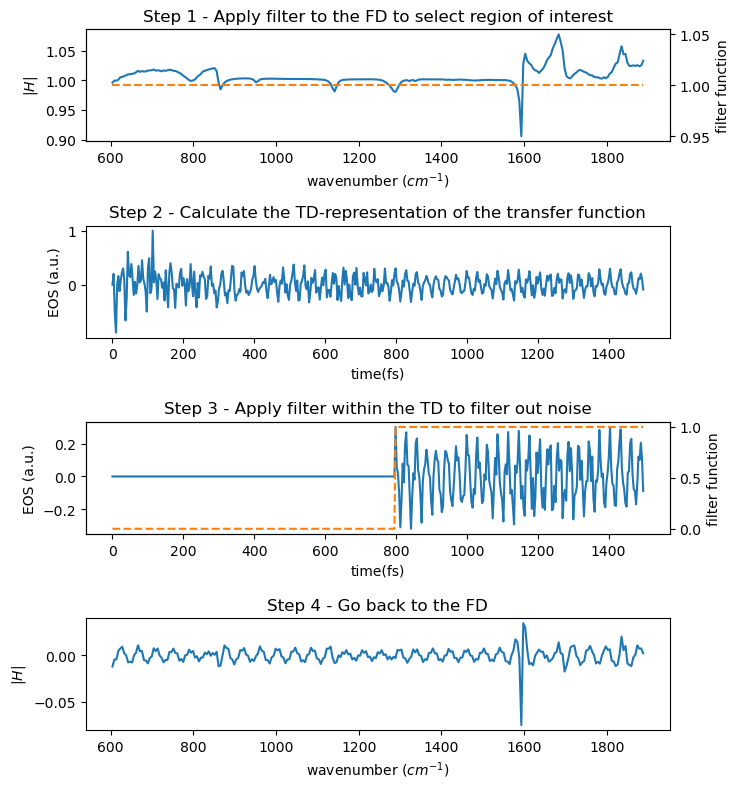

In [18]:
f, y = np.load(r'data\DMSO2.npz')['x'], np.load(r'data\DMSO2.npz')['y']
t1 = 800
f1, f2   = (np.abs(f - 1000)).argmin(), (np.abs(f  - 1500)).argmin()

t = fft.rfftfreq(f.size, d=np.diff(f*constants.c*100).mean())*1E15 # calculated time-axis
w_f = SD.tukeyF(f,1000,1500,0)

y_f, y_tdf, t, At, At_f, w_f, w_t = tdf.rtdf(f, (y.real-1)*1+1, t1, w_f=1)
plottdfsteps(f, y_f, y_tdf, t, At, At_f, w_f, w_t, tag='Heavieside TD-filter', b_plotfilter = 1, f1=700, f2=1800)

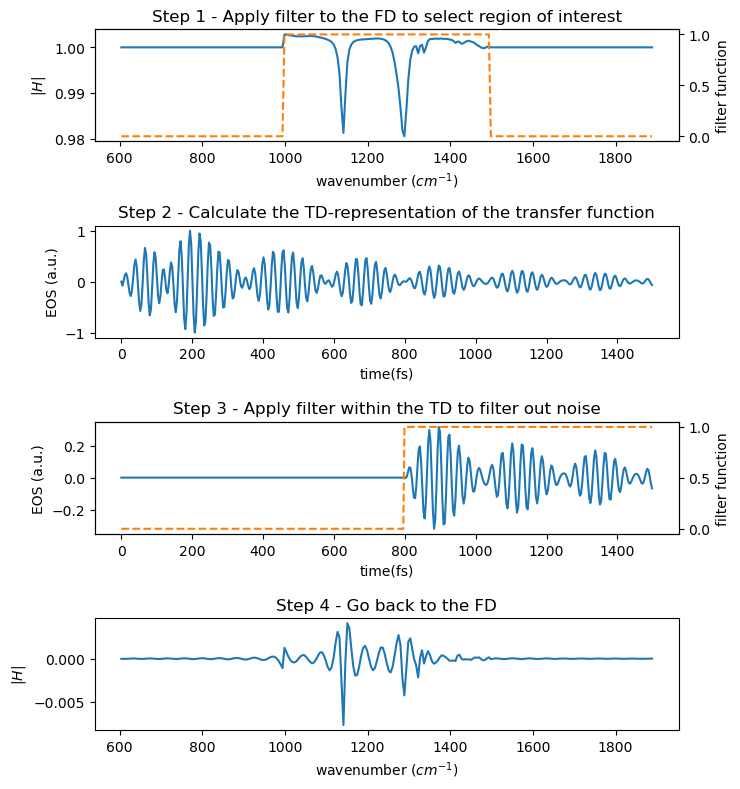

In [19]:
f, y = np.load(r'data\DMSO2.npz')['x'], np.load(r'data\DMSO2.npz')['y']
t1 = 800
f1, f2   = (np.abs(f - 1000)).argmin(), (np.abs(f  - 1500)).argmin()

t = fft.rfftfreq(f.size, d=np.diff(f*constants.c*100).mean())*1E15 # calculated time-axis
w_f = SD.tukeyF(f,1000,1500,0)

y_f, y_tdf, t, At, At_f, _, w_t = tdf.rtdf(f, (y.real-1)*w_f+1, t1, w_f=1)
plottdfsteps(f, y_f, y_tdf, t, At, At_f, w_f, w_t, tag='Heavieside TD-filter', b_plotfilter = 1, f1=700, f2=1800)

## Effect of the shape of the filter
In the following, filters from the scipy.signal package are applied to spectral data. These filters are originally designed for TD-data, but can also be applied to FD data. When doing so, special care has to be taken to convert the critical frequency (or frequencies) to correspondng values in the TD. This is can be done using the relatonship between wavenumbers and hertz via:

```
f_tdf = constants.c/1E12*t1
```

Thereby, `t1` is the value of the high-pass filter in the TD in units of fs, and `f_tdf` is the converted critical frequency that now can be used in the filter functions provided by scipy. Correspondingly, one has to make sure that the sampling frequency `fs` of the FD-axis `f` (essentially the resolution ) is set correctly:

```
fs=(10/np.diff(f).mean())
```

Any filter is then applied using the `signal.sosfiltfilt` function to avoid any phase delay.

The time-domain response of the filter can be calculated using `signal.sosfreqz`.
### Some examples

In [20]:
def tdf_sos(f, y, f1, f2, sos, w_f = np.array(0)):
    """
    calculates the Fourier-filtered version of a given complex transfer function
    f: frequency axis in wavenumber
    y: real-valued transfer function (all frequencies)
    f1, f2: frequency filter from f1 to f2 (in wavenumber)
    t1, t2: time filter from t1 to t2
    """
    
    # the following variables are calculated,
    # but not used, in order to have the same output format as the other implementations
    t = fft.rfftfreq(f.size, d=np.diff(f*constants.c*100).mean())*1E15 # calculated time-axis
    w_f = SD.tukeyF(f,f1,f2,25) if w_f.all() == 0 else w_f
    
    At = np.zeros(t.size)
    y_f = (y-1)*w_f
 
    # filtered input spectrum
    y_tdf = signal.sosfiltfilt(sos, y_f)
    
    # not sure about the following part
    At   = fft.rfft(y_f.real).real
    At_f = fft.rfft(y_tdf.real).real
    
    t, w_t = signal.sosfreqz(sos, worN=At.size, fs=(10/np.diff(f).mean()))
    t = t*1E12/constants.c
    w_t = np.abs(w_t)
        
    return y_f+1, y_tdf+1, t, At/At.max(), At_f/At.max(), w_f, w_t 

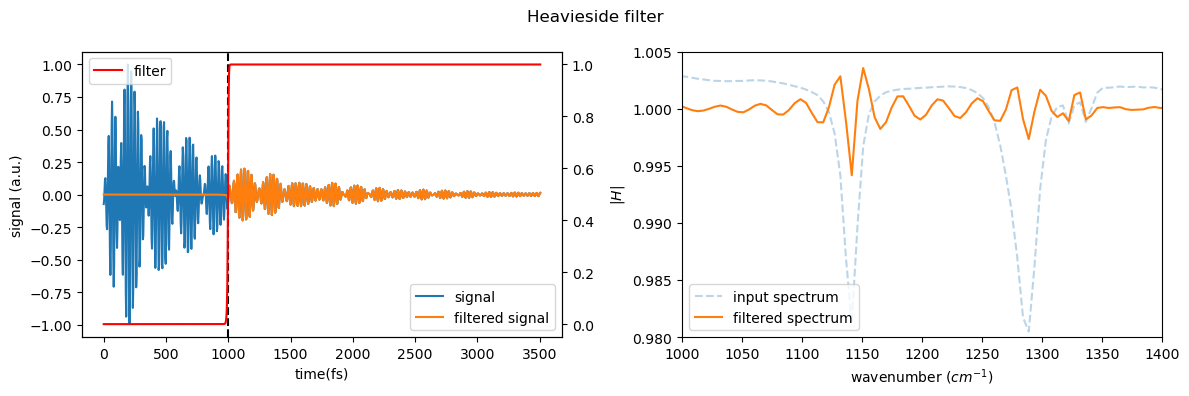

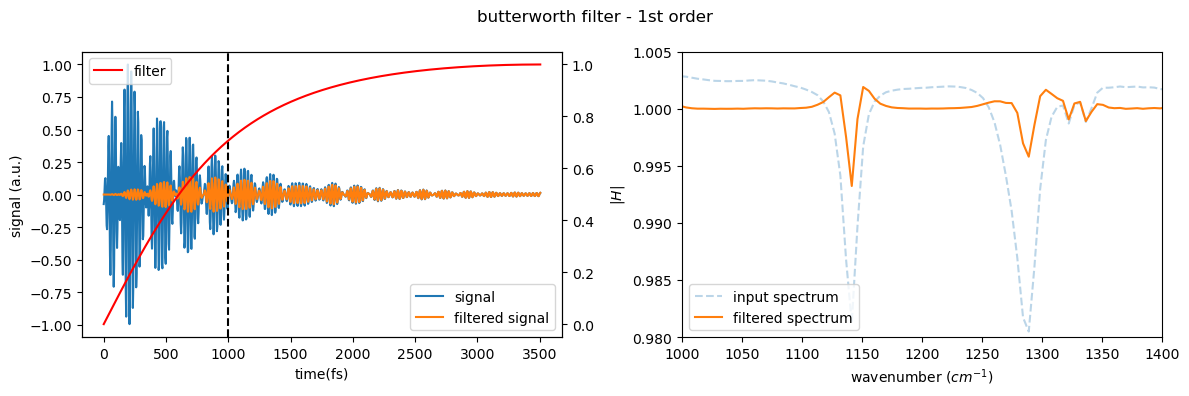

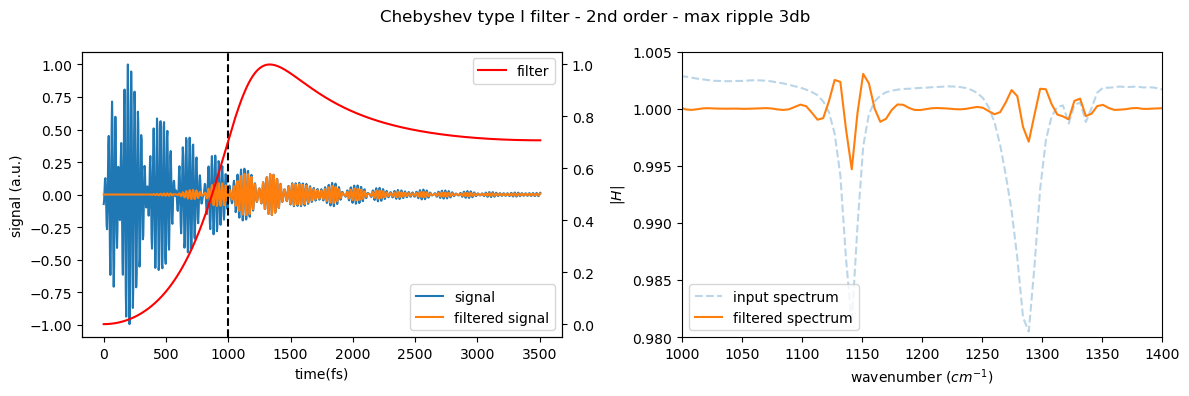

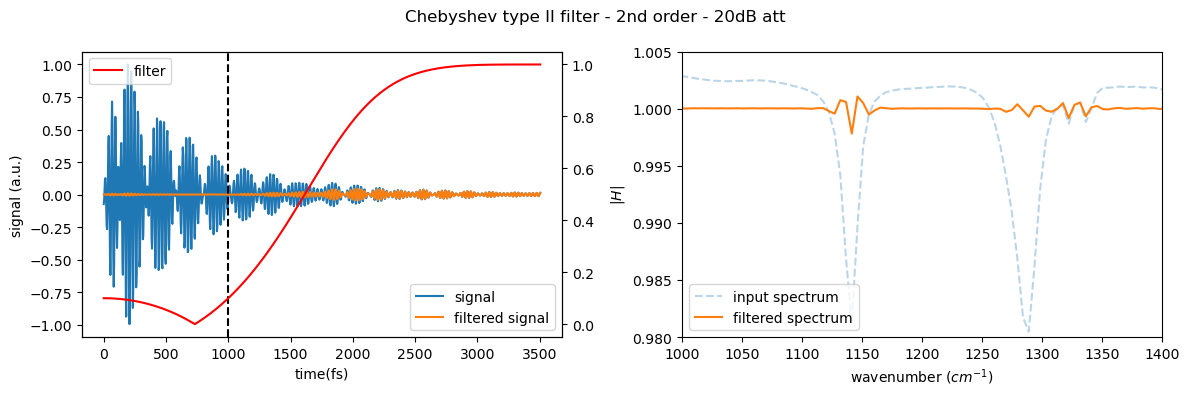

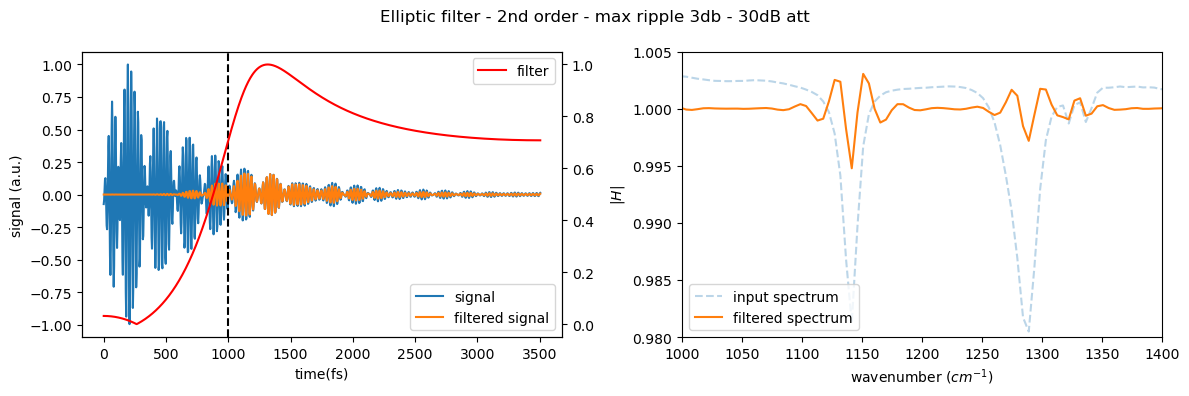

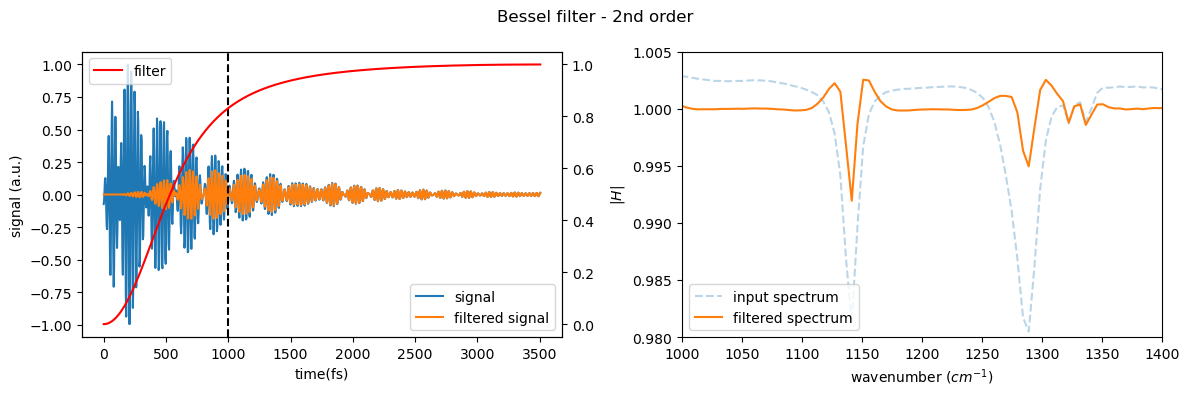

In [21]:
f, y = np.load(r'data\DMSO2.npz')['x'], np.load(r'data\DMSO2.npz')['y']
t1 = 1000
f1, f2   = (np.abs(f - 1000)).argmin(), (np.abs(f  - 1500)).argmin()

f_tdf = constants.c/1E12*t1
fs=(10/np.diff(f).mean())
sos_list = [
    [signal.butter(200, f_tdf, 'hp', output='sos', fs=fs), 'Heavieside filter'],
    [signal.butter(1, f_tdf, 'hp', output='sos', fs=fs), 'butterworth filter - 1st order'],
    [signal.cheby1(2, 3, f_tdf, 'hp', output='sos', fs=fs), 'Chebyshev type I filter - 2nd order - max ripple 3db'],
    [signal.cheby2(2, 20, f_tdf, 'hp', output='sos', fs=fs), 'Chebyshev type II filter - 2nd order - 20dB att'],
    [signal.ellip(2, 3, 30, f_tdf, 'hp', output='sos', fs=fs), 'Elliptic filter - 2nd order - max ripple 3db - 30dB att'],
    [signal.bessel(2, f_tdf, 'hp', output='sos', fs=fs, norm='delay'), 'Bessel filter - 2nd order'],
            ]


for [sos,label] in sos_list[:]:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
    y_f, y_tdf, t, At, At_f, w_f, w_t = tdf_sos(f, y, 1000, 1500, sos)
    ax11 = ax1.twinx()
    fig.suptitle(label)
    ax1.plot(t, At.real, label='signal')
    ax1.plot(t, (At_f.real), label='filtered signal')
    ax11.plot(t,w_t, label='filter', c='r')
    ax11.legend()
    ax1.legend(loc='lower right')
    ax1.set_xlabel("time(fs)"), ax1.set_ylabel("signal (a.u.)")
    ax1.axvline(t1, c='k', ls='--', label = 'cut-off value')

    ax2.plot(f,y.real, ls='--', alpha=0.3, label ='input spectrum')
    ax2.plot(f,y_tdf.real, label ='filtered spectrum')
    ax2.set_xlabel("wavenumber ($cm^{-1}$)"), ax2.set_ylabel("$|H|$")
    ax2.legend()
    ax2.set_xlim(1000,1400), ax2.set_ylim(0.98,1.005)
    plt.tight_layout()